## Pregunta 1

In [2]:
# Importamos librerías  
import pandas as pd 
import numpy as np
import re 
from tqdm import tqdm  # Controlar el tiempo en un loop
import os

# Librería de modelo lineal
import statsmodels.api as sm  # linear regression utiliza todas las columnas de base de datos 
import statsmodels.formula.api as smf  # linear regression usa uan formula
from stargazer.stargazer import Stargazer
from sklearn import datasets, linear_model # Modelos  
from sklearn.metrics import mean_squared_error, r2_score
import econtools.metrics as mt
from linearmodels.iv import IV2SLS # Para IV regression
import warnings
warnings.filterwarnings('ignore') # Eliminar los warning messages 

# Para poder exportar la tabla a latex  
from pystout import pystout

#plots library
import matplotlib.pyplot as plt
import seaborn as sns

# Seteamos el directorio 
user = os.getlogin()   # Username
os.chdir(f"C:/Users/{user}/Documents/GitHub/1ECO35_2022_2/Trabajo_final/datos") 


In [3]:
# Cargamos la base de datos
# Ponemos "False" para que no lea las etiquetas de valor
repdata = pd.read_stata(r"../datos/mss_repdata.dta",
                           convert_categoricals=False)
# Mostramos la base de datos 
repdata

,ccode,year,country_name,country_code,GPCP,GPCP_l,GPCP_l2,GPCP_g,GPCP_g_l,GPCP_g_fl,...,muni,state,author,stconst,fh_civ,fh_pol,S,W,WoverS,soc
0,540.0,1981-01-01,Angola,AGO,839.215759,911.847290,1021.776855,-0.079653,-0.107587,0.155680,...,0.0,1.0,NaN,NaN,0.000000,0.000000,1.0,0.5,0.500712,1.0
1,540.0,1982-01-01,Angola,AGO,969.864563,839.215759,911.847290,0.155680,-0.079653,-0.034482,...,0.0,1.0,NaN,NaN,0.000000,0.000000,1.0,0.5,0.500712,1.0
2,540.0,1983-01-01,Angola,AGO,936.421631,969.864563,839.215759,-0.034482,0.155680,0.059925,...,0.0,1.0,NaN,NaN,0.000000,0.000000,1.0,0.5,0.500712,1.0
3,540.0,1984-01-01,Angola,AGO,992.536255,936.421631,969.864563,0.059925,-0.034482,-0.018277,...,0.0,1.0,NaN,NaN,0.000000,0.000000,1.0,0.5,0.500712,1.0
4,540.0,1985-01-01,Angola,AGO,974.396118,992.536255,936.421631,-0.018277,0.059925,0.216019,...,0.0,1.0,NaN,NaN,0.000000,0.000000,1.0,0.5,0.500712,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,552.0,1995-01-01,Zimbabwe,ZWE,493.448456,465.000092,680.722412,0.061179,-0.316902,0.513642,...,NaN,0.0,NaN,NaN,0.333333,0.333333,1.0,0.5,0.500712,0.0
739,552.0,1996-01-01,Zimbabwe,ZWE,746.904236,493.448456,465.000092,0.513642,0.061179,0.044380,...,NaN,0.0,NaN,NaN,0.333333,0.333333,1.0,0.5,0.500712,0.0
740,552.0,1997-01-01,Zimbabwe,ZWE,780.051941,746.904236,493.448456,0.044380,0.513642,-0.181482,...,NaN,0.0,NaN,NaN,0.333333,0.333333,1.0,0.5,0.500712,0.0
741,552.0,1998-01-01,Zimbabwe,ZWE,638.486389,780.051941,746.904236,-0.181482,0.044380,0.094420,...,NaN,0.0,NaN,NaN,0.333333,0.333333,1.0,0.5,0.500712,0.0


In [4]:
# Descripción de la base de datos
repdata.describe()
# Información de las variables para conocer su tipo 
repdata.info()
repdata.dtypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 743 entries, 0 to 742
Columns: 200 entries, ccode to soc
dtypes: datetime64[ns](1), float32(104), float64(78), int32(9), int8(5), object(3)
memory usage: 813.4+ KB


ccode                  float64
year            datetime64[ns]
country_name            object
country_code            object
GPCP                   float32
                     ...      
fh_pol                 float64
S                      float32
W                      float32
WoverS                 float32
soc                    float32
Length: 200, dtype: object

In [5]:
# Se resta el año inicial a cada año para que los resultados sean más pequeños
repdata['time_year'] = pd.DatetimeIndex(repdata['year']).year - 1978
repdata['time_year']

0       3
1       4
2       5
3       6
4       7
       ..
738    17
739    18
740    19
741    20
742    21
Name: time_year, Length: 743, dtype: int64

In [6]:
dummys = pd.get_dummies(repdata["ccode"].astype(int), prefix = "ccode", dummy_na=False)
dummys.columns

# ccode es un float, necesitamos pasarlo a entero con el prefijo ccode
# dummy_na=False te dice que no cree dummy para valores missing 
# se convierte a entero repdata["ccode"].astype(int)
# ccode: código por país 
# dummy_na=False 
# se crea una dummy por país para capturar variables omitidas invariantes de cada país 
# es una base de datos que tiene información geográfica

Index(['ccode_404', 'ccode_420', 'ccode_432', 'ccode_433', 'ccode_434',
       'ccode_435', 'ccode_436', 'ccode_437', 'ccode_438', 'ccode_439',
       'ccode_450', 'ccode_451', 'ccode_452', 'ccode_461', 'ccode_471',
       'ccode_475', 'ccode_481', 'ccode_482', 'ccode_483', 'ccode_484',
       'ccode_490', 'ccode_500', 'ccode_501', 'ccode_510', 'ccode_516',
       'ccode_517', 'ccode_520', 'ccode_522', 'ccode_530', 'ccode_540',
       'ccode_541', 'ccode_551', 'ccode_552', 'ccode_553', 'ccode_560',
       'ccode_565', 'ccode_570', 'ccode_571', 'ccode_572', 'ccode_580',
       'ccode_625'],
      dtype='object')

In [7]:
dummys

,ccode_404,ccode_420,ccode_432,ccode_433,ccode_434,ccode_435,ccode_436,ccode_437,ccode_438,ccode_439,...,ccode_551,ccode_552,ccode_553,ccode_560,ccode_565,ccode_570,ccode_571,ccode_572,ccode_580,ccode_625
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
739,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
740,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
741,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [8]:
len(dummys.columns)

41

In [9]:
# Así unimos ambas bases de datos de manera horizontal
repdata = pd.concat([ repdata , dummys], axis = 1 )

# concantenar ambas bases de datos de manera horizontal (axis = 1)

In [10]:
repdata

,ccode,year,country_name,country_code,GPCP,GPCP_l,GPCP_l2,GPCP_g,GPCP_g_l,GPCP_g_fl,...,ccode_551,ccode_552,ccode_553,ccode_560,ccode_565,ccode_570,ccode_571,ccode_572,ccode_580,ccode_625
0,540.0,1981-01-01,Angola,AGO,839.215759,911.847290,1021.776855,-0.079653,-0.107587,0.155680,...,0,0,0,0,0,0,0,0,0,0
1,540.0,1982-01-01,Angola,AGO,969.864563,839.215759,911.847290,0.155680,-0.079653,-0.034482,...,0,0,0,0,0,0,0,0,0,0
2,540.0,1983-01-01,Angola,AGO,936.421631,969.864563,839.215759,-0.034482,0.155680,0.059925,...,0,0,0,0,0,0,0,0,0,0
3,540.0,1984-01-01,Angola,AGO,992.536255,936.421631,969.864563,0.059925,-0.034482,-0.018277,...,0,0,0,0,0,0,0,0,0,0
4,540.0,1985-01-01,Angola,AGO,974.396118,992.536255,936.421631,-0.018277,0.059925,0.216019,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,552.0,1995-01-01,Zimbabwe,ZWE,493.448456,465.000092,680.722412,0.061179,-0.316902,0.513642,...,0,1,0,0,0,0,0,0,0,0
739,552.0,1996-01-01,Zimbabwe,ZWE,746.904236,493.448456,465.000092,0.513642,0.061179,0.044380,...,0,1,0,0,0,0,0,0,0,0
740,552.0,1997-01-01,Zimbabwe,ZWE,780.051941,746.904236,493.448456,0.044380,0.513642,-0.181482,...,0,1,0,0,0,0,0,0,0,0
741,552.0,1998-01-01,Zimbabwe,ZWE,638.486389,780.051941,746.904236,-0.181482,0.044380,0.094420,...,0,1,0,0,0,0,0,0,0,0


In [11]:
# Creación del trend_country effects : multiplicación de la dummy por país y la variable temporal 
# capturar variables omitidas variantes en el tiempo por cada país 
i = 0

while i < 41:  # 41 por el tema de indexing pues en python la posición inicial es cero. 
    var = dummys.columns[i]+"_"+"time"  # creamos el nombre de cada variable
    repdata[var]  = repdata[dummys.columns[i]]*repdata["time_year"] # multiplicación de variables
    # multiplicacón de variables: dummy país * variable temporal

    i = i + 1

In [12]:
# observamos para país y la variable temporarl. 
# primeras 40 observaciones 
repdata[['ccode','time_year']].iloc[0:40,:]

,ccode,time_year
0,540.0,3
1,540.0,4
2,540.0,5
3,540.0,6
4,540.0,7
5,540.0,8
6,540.0,9
7,540.0,10
8,540.0,11
9,540.0,12


In [13]:
# Seleccionamos las variables para las estadísticas descriptivas
tab1 = repdata.loc[:,["NDVI_g", "tot_100", "trade_pGDP", "pop_den_rur", 
                        "land_crop", "va_agr", "va_ind_manf"]]
# Mostramos la base de datos 
tab1 

,NDVI_g,tot_100,trade_pGDP,pop_den_rur,land_crop,va_agr,va_ind_manf
0,NaN,NaN,NaN,197.384522,0.401059,NaN,NaN
1,NaN,NaN,NaN,202.516861,0.401059,NaN,NaN
2,-0.032181,NaN,NaN,207.917908,0.401059,NaN,NaN
3,0.011718,NaN,NaN,213.458649,0.401059,NaN,NaN
4,0.043623,127.930000,61.056736,218.983582,0.401059,13.548707,9.695752
...,...,...,...,...,...,...,...
738,-0.022146,100.000000,79.156792,254.089279,0.336048,15.235192,21.795248
739,0.192235,100.100000,72.069618,249.467636,0.336048,21.771107,18.780670
740,0.048942,109.650000,82.205071,244.998810,0.336048,18.934082,18.007488
741,-0.067663,108.990000,93.679726,249.493622,0.336048,21.788530,16.627857


In [14]:
# Seleccionamos los estadísticos de interés: media, error estándar y cantidad de observaciones
sum_tab = tab1.describe().loc[["mean","std","count"]]
sum_tab

,NDVI_g,tot_100,trade_pGDP,pop_den_rur,land_crop,va_agr,va_ind_manf
mean,0.009282,109.877568,64.252421,324.816053,1.979464,32.181401,11.117373
std,0.093208,34.684560,34.291007,193.093648,3.373026,15.166560,6.262198
count,646.000000,668.000000,698.000000,720.000000,701.000000,702.000000,669.000000


In [15]:
# Es lo mismo que table, pero es su traspuesta 
sum_tab = tab1.describe().loc[["mean","std","count"]].T
sum_tab
# .t permite tranponer el DataFrame

,mean,std,count
NDVI_g,0.009282,0.093208,646.0
tot_100,109.877568,34.684560,668.0
trade_pGDP,64.252421,34.291007,698.0
pop_den_rur,324.816053,193.093648,720.0
land_crop,1.979464,3.373026,701.0
va_agr,32.181401,15.166560,702.0
va_ind_manf,11.117373,6.262198,669.0


In [16]:
# Mostramos los nombres de las columnas 
tab1.columns

Index(['NDVI_g', 'tot_100', 'trade_pGDP', 'pop_den_rur', 'land_crop', 'va_agr',
       'va_ind_manf'],
      dtype='object')

In [17]:
tab1.columns

# lista con los nuevos nombres 
nuevos = ["Tasa de variación del índice de vegetación", "Términos de intercambio", 
             "Porcentaje de las exportaciones respecto al PBI", "Densidad poblacional rural",
             "Porcentaje de tierra cultivable en uso", "Valor agregado del sector agrícola respecto al PBI",
             "Valor agregado del sector manufacturero respecto al PBI"]

# Unimos la lista de nombres viejos con la lista de nombres nuevos por medio de un diccionario
dict(zip(tab1.columns, nuevos) )

{'NDVI_g': 'Tasa de variación del índice de vegetación',
 'tot_100': 'Términos de intercambio',
 'trade_pGDP': 'Porcentaje de las exportaciones respecto al PBI',
 'pop_den_rur': 'Densidad poblacional rural',
 'land_crop': 'Porcentaje de tierra cultivable en uso',
 'va_agr': 'Valor agregado del sector agrícola respecto al PBI',
 'va_ind_manf': 'Valor agregado del sector manufacturero respecto al PBI'}

In [18]:
# Personalizamos la tabla de resumen 

# A los nombres viejos y nuevos los voy a llamar index
index_nuevos = dict(zip(tab1.columns, nuevos))

# Con esto cambio el nombre de las columnas 
columns_nuevos = {
    "mean": "Media",
    "std": "Desviación estándar",
    "count": "Observaciones",
}

# Con Summary table voy a hacer un rename de index de columnas y filas 
sum_tab.rename(index=index_nuevos, columns=columns_nuevos, inplace=True)


In [19]:
# Mostramos la tabla de resultados 
sum_tab

,Media,Desviación estándar,Observaciones
Tasa de variación del índice de vegetación,0.009282,0.093208,646.0
Términos de intercambio,109.877568,34.684560,668.0
Porcentaje de las exportaciones respecto al PBI,64.252421,34.291007,698.0
Densidad poblacional rural,324.816053,193.093648,720.0
Porcentaje de tierra cultivable en uso,1.979464,3.373026,701.0
Valor agregado del sector agrícola respecto al PBI,32.181401,15.166560,702.0
Valor agregado del sector manufacturero respecto al PBI,11.117373,6.262198,669.0


In [20]:
# Cambiamos la cantidad de decimales que me va mostrar
# En Media y Desviación estándar mostramos solo 2 decimales
# Observaciones como es un número entero se indica que no muestre ningún decimal
sum_tab.style.format(subset="Media", precision=2).\
format(subset="Desviación estándar", precision=2).format(subset="Observaciones", precision=0)

,Media,Desviación estándar,Observaciones
Tasa de variación del índice de vegetación,0.01,0.09,646
Términos de intercambio,109.88,34.68,668
Porcentaje de las exportaciones respecto al PBI,64.25,34.29,698
Densidad poblacional rural,324.82,193.09,720
Porcentaje de tierra cultivable en uso,1.98,3.37,701
Valor agregado del sector agrícola respecto al PBI,32.18,15.17,702
Valor agregado del sector manufacturero respecto al PBI,11.12,6.26,669


In [21]:
# Generamos un código para poder exportar está tabla a LaTex
sum_tab.style.format(subset="Media", precision=2).format(subset="Desviación estándar", precision=2)\
.format(subset="Observaciones", precision=0)\
.to_latex(
    "sum.tex",
caption="Estadísticas Descriptivas",
    column_format = "lccc"   
) 

# Indicamos que la primera columna vaya a la izquierda y las otras tres columnas con formato centrado
# Es decir, el l significa left y cada c significa center 
# El código lo copiamos y pegamos en LaTex

### Model OLS (1):
- Variable endógena: any_prio
- Variables explicativas: GPCP_g y GPCP_g_l
- Si efectos fijos (country)
- Si country-time trends
- Errores estándar robustos (Huber-White robust)
- Los términos de perturbación están clusterizados (agrupados) a nivel país
- No se añade variables de control

In [22]:
# Definimos la variable endógena 
y1 = repdata["any_prio"]

# Agregamos las variables explicativas
X1 = sm.add_constant(repdata.loc[:,["GPCP_g", "GPCP_g_l"]])
X1

,const,GPCP_g,GPCP_g_l
0,1.0,-0.079653,-0.107587
1,1.0,0.155680,-0.079653
2,1.0,-0.034482,0.155680
3,1.0,0.059925,-0.034482
4,1.0,-0.018277,0.059925
...,...,...,...
738,1.0,0.061179,-0.316902
739,1.0,0.513642,0.061179
740,1.0,0.044380,0.513642
741,1.0,-0.181482,0.044380


In [23]:
# Planteamos el modelo de homogeneidad homocedástica 
ols_model_1 = sm.OLS(y1, X1).fit()

In [24]:
# Mostramos la primera tabla del modelo OLS 
# En este extracto encontramos información general de las variables
# Podemos ver el R cuadrado y el ajustado, así como el F estadístico y número de observaciones
# Recordemos que en Python los valores empiezan a contar a partir de 0
ols_model_1.summary().tables[0]

Dep. Variable:,any_prio,R-squared:,0.003
Model:,OLS,Adj. R-squared:,0.000
Method:,Least Squares,F-statistic:,1.008
Date:,"Sun, 11 Dec 2022",Prob (F-statistic):,0.366
Time:,04:33:14,Log-Likelihood:,-448.04
No. Observations:,743,AIC:,902.1
Df Residuals:,740,BIC:,915.9
Df Model:,2,,
Covariance Type:,nonrobust,,


In [25]:
# Mostramos la segunda tabla del modelo OLS
# Podemos ver los valores de los coeficientes y las desviaciones estándar de las variables 
# Además, el p-value para saber su significancia y los intervalos de confianza
ols_model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.2697,0.016,16.449,0.000,0.238,0.302
GPCP_g,-0.0288,0.085,-0.339,0.735,-0.196,0.138
GPCP_g_l,-0.1204,0.086,-1.397,0.163,-0.290,0.049


In [26]:
# Mostramos la tercera tabla del modelo OLS
# Podemos ver algunos test como el Durbin Watson, Jarque-Bera y la Kurtosis 
ols_model_1.summary().tables[2]

Omnibus:,189.379,Durbin-Watson:,0.530
Prob(Omnibus):,0.000,Jarque-Bera (JB):,159.939
Skew:,1.044,Prob(JB):,1.86e-35
Kurtosis:,2.104,Cond. No.,6.26


In [27]:
# Imprimimos todas las tablas juntas 
# Vemos que simula bastante bien la presentación de Stata
print(ols_model_1.summary())

                            OLS Regression Results                            
Dep. Variable:               any_prio   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.008
Date:                Sun, 11 Dec 2022   Prob (F-statistic):              0.366
Time:                        04:33:14   Log-Likelihood:                -448.04
No. Observations:                 743   AIC:                             902.1
Df Residuals:                     740   BIC:                             915.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2697      0.016     16.449      0.0

In [28]:
# Errores estándar robustos 
# HC1: error estándar robusto frente a la heterocedasticidad
ols_model_rb = sm.OLS(y1, X1).fit(cov_type = "HC1")
print(ols_model_rb.summary())

                            OLS Regression Results                            
Dep. Variable:               any_prio   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.014
Date:                Sun, 11 Dec 2022   Prob (F-statistic):              0.363
Time:                        04:33:14   Log-Likelihood:                -448.04
No. Observations:                 743   AIC:                             902.1
Df Residuals:                     740   BIC:                             915.9
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2697      0.016     16.374      0.0

In [29]:
# Acceder a la información de la tabla
ols_model_rb.summary2()
ols_model_rb.summary2().tables[1]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,0.269715,0.016473,16.373626,2.950944e-60,0.237430,0.302001
GPCP_g,-0.028825,0.089833,-0.320878,7.483026e-01,-0.204894,0.147244
GPCP_g_l,-0.120448,0.086574,-1.391273,1.641426e-01,-0.290129,0.049234


In [30]:
# Lista de atributos y métodos 
dir(ols_model_rb)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abat_diagonal',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_get_robustcov_results',
 '_is_nested',
 '_use_t',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_params_default',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 'get_influence',
 'get_prediction',
 'get_robus

In [31]:
# Y estimados a partir del método predict 
sm.OLS(y1, X1).fit().predict()

array([0.28496978, 0.2748217 , 0.25195793, 0.27214113, 0.26302426,
       0.26568972, 0.2466797 , 0.27791809, 0.25526007, 0.28224195,
       0.26917588, 0.30081865, 0.28540232, 0.21866934, 0.2861791 ,
       0.27253843, 0.27999266, 0.27934855, 0.26917232, 0.28043463,
       0.27237109, 0.26828123, 0.27929381, 0.25381756, 0.26769429,
       0.27252959, 0.27744108, 0.24540483, 0.2622242 , 0.28374367,
       0.22578955, 0.28753694, 0.26812988, 0.25210689, 0.2885355 ,
       0.26993623, 0.26967236, 0.25559903, 0.24386254, 0.2739153 ,
       0.30170927, 0.26866805, 0.28991521, 0.24865613, 0.26155857,
       0.27105444, 0.17496034, 0.29626138, 0.29942372, 0.23988976,
       0.30644488, 0.18201347, 0.27697215, 0.25379256, 0.24793872,
       0.26968144, 0.29971203, 0.27894354, 0.27432929, 0.27281134,
       0.28310697, 0.25005254, 0.24888163, 0.27129552, 0.27677362,
       0.2524269 , 0.27155199, 0.28413026, 0.2312682 , 0.28199823,
       0.27089332, 0.2498764 , 0.28802241, 0.26710212, 0.26587

In [32]:
# predict para ello uso la función predict 
ols_model_1.predict(X1)
# acceso a los parámetros
print(ols_model_1.params)

# R2 y R2  ajustado
print(ols_model_1.rsquared)
print(ols_model_1.rsquared_adj)

const       0.269715
GPCP_g     -0.028825
GPCP_g_l   -0.120448
dtype: float64
0.0027161400455674167
2.0778261906828632e-05


In [33]:
control_formula = "any_prio ~ GPCP_g + GPCP_g_l"
ols_model_1 = smf.ols(control_formula, data=repdata).fit()
print(ols_model_1.summary())

                            OLS Regression Results                            
Dep. Variable:               any_prio   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.008
Date:                Sun, 11 Dec 2022   Prob (F-statistic):              0.366
Time:                        04:33:15   Log-Likelihood:                -448.04
No. Observations:                 743   AIC:                             902.1
Df Residuals:                     740   BIC:                             915.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2697      0.016     16.449      0.0

In [34]:
ols_model_skl_1 = linear_model.LinearRegression().fit(X1, y1)
ols_model_skl_1.coef_ # Acceso a coeficientes 
ols_model_skl_1.predict(X1) # Predicción en formato array 
ols_model_skl_1.score(X1,y1) # R cuadrado

0.0027161400455674167

In [35]:
dir(ols_model_skl_1)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_preprocess_data',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_residues',
 '_set_intercept',
 '_validate_data',
 'coef_',
 'copy_X',
 'feature_names_in_',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'n_features_in_',
 'n_jobs',
 'normalize',
 'positive',
 'predict',
 'rank_',
 'score',
 'set_params',
 'singular_']

In [36]:
mean_squared_error(y1, ols_model_1.predict())**0.5 # Errores cuadráticos medios 

0.4422283305322858

In [37]:
# Efectos Fijos por países 
index_columns = np.where( repdata.columns.str.contains(
    '_time$'))[0]

# Índice con nombre de variables que terminan con _time
country_trend = repdata.columns[index_columns] # se extrae el nombre de todas las variables que terminan con _time
country_trend 

Index(['ccode_404_time', 'ccode_420_time', 'ccode_432_time', 'ccode_433_time',
       'ccode_434_time', 'ccode_435_time', 'ccode_436_time', 'ccode_437_time',
       'ccode_438_time', 'ccode_439_time', 'ccode_450_time', 'ccode_451_time',
       'ccode_452_time', 'ccode_461_time', 'ccode_471_time', 'ccode_475_time',
       'ccode_481_time', 'ccode_482_time', 'ccode_483_time', 'ccode_484_time',
       'ccode_490_time', 'ccode_500_time', 'ccode_501_time', 'ccode_510_time',
       'ccode_516_time', 'ccode_517_time', 'ccode_520_time', 'ccode_522_time',
       'ccode_530_time', 'ccode_540_time', 'ccode_541_time', 'ccode_551_time',
       'ccode_552_time', 'ccode_553_time', 'ccode_560_time', 'ccode_565_time',
       'ccode_570_time', 'ccode_571_time', 'ccode_572_time', 'ccode_580_time',
       'ccode_625_time'],
      dtype='object')

In [38]:
formula_model_1 = "any_prio ~ GPCP_g + GPCP_g_l + C(ccode)" + ' + ' + ' + '.join(country_trend)
ols_model_1 = smf.ols(formula_model_1, data=repdata).fit(cov_type='cluster', cov_kwds={'groups': repdata['ccode']})
print(ols_model_1.summary())

rmse_ols_1 = round(mean_squared_error(y1, ols_model_1.predict())**0.5, 2)
print(rmse_ols_1)

                            OLS Regression Results                            
Dep. Variable:               any_prio   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     162.4
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           6.28e-20
Time:                        04:33:16   Log-Likelihood:                 8.6565
No. Observations:                 743   AIC:                             150.7
Df Residuals:                     659   BIC:                             538.0
Df Model:                          83                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.2458      0.00

### Model OLS (2):
- Variable endógena: war_prio
- Variables explicativas: GPCP_g y GPCP_g_l
- Si efectos fijos (country)
- Si country-time trends
- Errores estándar robustos (Huber-White robust)
- Los términos de perturbación están clusterizados (agrupados) a nivel país
- No se añade variables de control

In [39]:
# Definimos la variable endógena 
y2 = repdata["war_prio"]

# Agregamos las variables explicativas
X2 = sm.add_constant(repdata.loc[:,["GPCP_g", "GPCP_g_l"]])
X2

,const,GPCP_g,GPCP_g_l
0,1.0,-0.079653,-0.107587
1,1.0,0.155680,-0.079653
2,1.0,-0.034482,0.155680
3,1.0,0.059925,-0.034482
4,1.0,-0.018277,0.059925
...,...,...,...
738,1.0,0.061179,-0.316902
739,1.0,0.513642,0.061179
740,1.0,0.044380,0.513642
741,1.0,-0.181482,0.044380


In [40]:
# Planteamos el modelo de homogeneidad homocedástica 
ols_model_2 = sm.OLS(y2, X2).fit()
# Imprimimos todas las tablas juntas 
# Vemos que simula bastante bien la presentación de Stata
print(ols_model_2.summary())

                            OLS Regression Results                            
Dep. Variable:               war_prio   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.200
Date:                Sun, 11 Dec 2022   Prob (F-statistic):              0.302
Time:                        04:33:17   Log-Likelihood:                -320.10
No. Observations:                 743   AIC:                             646.2
Df Residuals:                     740   BIC:                             660.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1697      0.014     12.292      0.0

In [41]:
# Errores estándar robustos 
# HC1: error estándar robusto frente a la heterocedasticidad
ols_model_rb2 = sm.OLS(y2, X2).fit(cov_type = "HC1")
print(ols_model_rb2.summary())

                            OLS Regression Results                            
Dep. Variable:               war_prio   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.507
Date:                Sun, 11 Dec 2022   Prob (F-statistic):              0.222
Time:                        04:33:17   Log-Likelihood:                -320.10
No. Observations:                 743   AIC:                             646.2
Df Residuals:                     740   BIC:                             660.0
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1697      0.014     12.142      0.0

In [42]:
# Lista de atributos y métodos 
dir(ols_model_rb2)

# Y estimados a partir del método predict 
sm.OLS(y2, X2).fit().predict()

array([0.18704291, 0.16156761, 0.1591636 , 0.16689364, 0.16611632,
       0.15020309, 0.16052623, 0.16445212, 0.1678748 , 0.17493067,
       0.18461317, 0.21096717, 0.14646171, 0.14220873, 0.18236471,
       0.17711868, 0.18211489, 0.18210699, 0.14566715, 0.17998848,
       0.16871667, 0.17702256, 0.16698367, 0.15666318, 0.1680248 ,
       0.17984615, 0.16204504, 0.1430644 , 0.1802974 , 0.14964679,
       0.14789666, 0.18521695, 0.15446167, 0.16866698, 0.18319467,
       0.17212033, 0.15998443, 0.16219266, 0.14809908, 0.19410448,
       0.18898141, 0.18438161, 0.1734193 , 0.14512834, 0.17947203,
       0.1080412 , 0.11027748, 0.21478754, 0.16391527, 0.1845413 ,
       0.13976727, 0.11104919, 0.16801464, 0.14509102, 0.14936252,
       0.18708431, 0.19845518, 0.17957136, 0.17248373, 0.18268706,
       0.1702437 , 0.14207546, 0.15359244, 0.1777945 , 0.16454007,
       0.15436827, 0.186385  , 0.15436469, 0.14794209, 0.18320195,
       0.15511713, 0.166916  , 0.18187508, 0.16644452, 0.16207

In [43]:
# predict para ello uso la función predict 
ols_model_2.predict(X2)

# acceso a los parámetros
print(ols_model_2.params)

# R2 y R2  ajustado
print(ols_model_2.rsquared)
print(ols_model_2.rsquared_adj)

const       0.169673
GPCP_g     -0.097672
GPCP_g_l   -0.089139
dtype: float64
0.003232131465761179
0.0005381642535065012


In [44]:
control_formula_2 = "war_prio ~ GPCP_g + GPCP_g_l"
ols_model_2 = smf.ols(control_formula_2, data=repdata).fit()
print(ols_model_2.summary())

                            OLS Regression Results                            
Dep. Variable:               war_prio   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.200
Date:                Sun, 11 Dec 2022   Prob (F-statistic):              0.302
Time:                        04:33:17   Log-Likelihood:                -320.10
No. Observations:                 743   AIC:                             646.2
Df Residuals:                     740   BIC:                             660.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1697      0.014     12.292      0.0

In [45]:
ols_model_skl_2 = linear_model.LinearRegression().fit(X2, y2)
ols_model_skl_2.coef_ # Acceso a coeficientes 
ols_model_skl_2.predict(X2) # Predicción en formato array 
ols_model_skl_2.score(X2,y2) # R cuadrado

0.003232131465761179

In [46]:
dir(ols_model_skl_2)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_preprocess_data',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_residues',
 '_set_intercept',
 '_validate_data',
 'coef_',
 'copy_X',
 'feature_names_in_',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'n_features_in_',
 'n_jobs',
 'normalize',
 'positive',
 'predict',
 'rank_',
 'score',
 'set_params',
 'singular_']

In [47]:
mean_squared_error(y2, ols_model_2.predict())**0.5 # Errores cuadrados medios 

0.3722754239552763

In [48]:
formula_model_2 = "war_prio ~ GPCP_g + GPCP_g_l + C(ccode)" + ' + ' + ' + '.join(country_trend)
ols_model_2 = smf.ols(formula_model_2, data=repdata).fit(cov_type='cluster', cov_kwds={'groups': repdata['ccode']})
print(ols_model_2.summary())

                            OLS Regression Results                            
Dep. Variable:               war_prio   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     335.5
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           1.01e-25
Time:                        04:33:18   Log-Likelihood:                 124.86
No. Observations:                 743   AIC:                            -81.72
Df Residuals:                     659   BIC:                             305.6
Df Model:                          83                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1101      0.00

In [49]:
rmse_ols_2 = round(mean_squared_error(y2, ols_model_2.predict())**0.5, 2)
print(rmse_ols_2)

0.2


### TABLE 3:  Rainfall and Civil Conflict (Reduced-Form)

In [50]:
# Lista de explicativa a mostrarse en la tabla
explicativas = ['GPCP_g','GPCP_g_l']

# Etiquetas a las variables 
etiquetas = ['Growth in rainfall, t','Growth in rainfall, t-1','Country fixed effects',
             'Country-specific time trends','R^2', 'Root mean square error', 'Observations']

# Unimos las explicativas y las etiquetas
labels = dict(zip(explicativas,etiquetas))
labels 

{'GPCP_g': 'Growth in rainfall, t', 'GPCP_g_l': 'Growth in rainfall, t-1'}

In [51]:
pystout(models= [ols_model_1, ols_model_2], file='regression_table.tex', digits=3,
        endog_names= ['(1)','(2)'],
        exogvars= explicativas ,  # Seleccionamos las variables 
        varlabels= labels,  # Etiquetas a las variables
        mgroups= {'Ordinary Least Squares':[1,5]}, # Título a las regresiones
        modstat= {'nobs':'Observations','rsquared':'R\sym{2}'}, # Estadísticos 
        addrows= {'Country fixed effects': ['yes','yes'], 
                  'Country-specific time trends': ['yes','yes'],
                  'Root mean square error': [rmse_ols_1, rmse_ols_2]}, # Añadimos filas 
        addnotes= ['Note.—Huber robust standard errors are in parentheses.',
                   'Regression disturbance terms are clustered at the country level.',
                   'A country-specific year time trend is included in all specifications (coefficient estimates not reported).',
                   '* Significantly different from zero at 90 percent confidence.',
                   '** Significantly different from zero at 95 percent confidence.',
                   '*** Significantly different from zero at 99 percent confidence.'],
        title= 'TABLE 3  - Rainfall and Civil Conflict (Reduced-Form)',
        stars= {.1:'*',.05:'**',.01:'***'}
       )

# Las tables en latex se guardan en el archivo regression_table
# endog_names: nombre de las variables endógenas. En este caso solo son numerales
# exogvars: selecciona las variables explicativas 

### Gráfico Coeft plot

In [52]:
model1 = smf.ols(formula_model_1, data=repdata).fit(cov_type = 'HC1').summary2().tables[1]
# Extraemos el coeficiente de la variable explicativa GPCP_g
model1_coef = model1.iloc[41,0]  # Fila 41 y columna  0
model1_coef_se = model1.iloc[41,1] # Fila 41 y columna 1

# Extraemos los intervalos de confianza 
model1_lower = model1.iloc[41,4] # Límite inferior 
model1_upper = model1.iloc[41,5] # Límite superior

In [53]:
# Gráficamos el modelo 2 donde war_prio es la variable endógena
model2 = smf.ols(formula_model_2, data=repdata).fit(cov_type = 'HC1').summary2().tables[1]

# Extraemos el coeficiente de la variable explicativa GPCP_g
model2_coef = model2.iloc[41,0]  # Fila 41 y columna  0
model2_coef_se = model2.iloc[41,1] # Fila 41 y columna 1

# Extraemos los intervalos de confianza 
model2_lower = model2.iloc[41,4] # Límite inferior 
model2_upper = model2.iloc[41,5] # Límite superior

In [54]:
# Creamos una tabla de ceros de 2 filas y 4 columnas 
table = np.zeros( ( 2, 4 ) )

# Agregamos los valores extraídos previamente en la tabla nueva
table[0,0] = model1_coef
table[0,1] = model1_coef_se 
table[0,2] = model1_lower
table[0,3] = model1_upper 

table[1,0] = model2_coef
table[1,1] = model2_coef_se  
table[1,2] = model2_lower
table[1,3] = model2_upper 

# Convertimos la tabla a un dataframe y nombramos las columnas creadas anteriormente
table_pandas = pd.DataFrame(table, columns = [ "Estimate", "Std. Error", "Lower_bound" , "Upper_bound"])
table_pandas.index = ["OLS 1","OLS 2"]

# Reseteamos el index y pedimos con inplace=True que los datos se guarden 
table_pandas.reset_index(inplace = True)

# Renombramos el nombre del index como Model y pedimos con inplace=True que los datos se guarden 
table_pandas.rename(columns = {"index" : "Model"}, inplace = True)

# Mostramos la tabla creada 
table_pandas.round(8)

,Model,Estimate,Std. Error,Lower_bound,Upper_bound
0,OLS 1,-0.023770,0.051961,-0.125613,0.078072
1,OLS 2,-0.062476,0.037690,-0.136348,0.011395


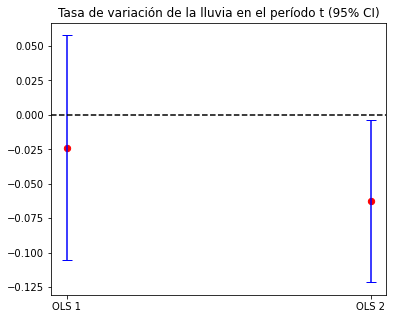

In [58]:
# Creamos la gráfica Coeft plot
fig, ax = plt.subplots(figsize=(6, 5)) # Tamaño de la figura 

ax.scatter(x= table_pandas['Model'], 
           marker= 'o', s= 40,  # s: modificar tamaño del point (punto rojo)
           y= table_pandas['Estimate'], color = "red")

eb1 = plt.errorbar(x=table_pandas['Model'], y=table_pandas['Estimate'],
            yerr = 0.4*(table_pandas['Upper_bound']-table_pandas['Lower_bound']),
            color = 'blue', ls='', capsize = 5)

# ls='': no une los puntos rojos 
# yerr genera el gráfico del intervalo de confianza, va decir cuanto hacia arriba y abajo
# capsize es el tamaño de las rayitas al final del intervalo de confianza

plt.axhline(y=0, color = 'black').set_linestyle('--')  # Línea horizontal 
plt.title('Tasa de variación de la lluvia en el período t (95% CI)',fontsize=12) # Título del gráfico
plt.savefig("Imagen_1.jpg", bbox_inches='tight') # Guardamos la imagen para copiarlo en el informe 